<a href="https://colab.research.google.com/github/BarkinTopcu/company_forecasting/blob/main/D01_Deep_Learning_Method_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Sales Forecasting with AI Based - Daily Forecasting
This code documentation and code is written by Recep Barkın Topcu.

The dataset is taken from kaggle: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview

This code just focus on the company transaction without store based. All sales of the all stores at each day are gathered together.

# Data Preprocessing

These part are already done in D00. However, I will show you again.

In [1]:
pip install modin[ray] -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.5 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
#modin pandas is faster than pandas
import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd

In [4]:
#Dask is used for reading the csv. When I was using pandas in the other projects sometimes pandas cannot read all of the data. For that reason I prefer to use dask.
sales_df = dd.read_csv("transactions.csv")
sales_df = sales_df.compute()
sales_df

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [5]:
sales_df.drop(index=0,inplace=True) #There is only one sales info at 2013-01-01. I am deleting this data because of that.
sales_df["date"] = pd.to_datetime(sales_df["date"]) #Converting date column to datetime format
#Gathering all transactions of the all stores for each day.
sales_df = sales_df.groupby("date",as_index=False).agg({"transactions":"sum"})
#I added some columns for deep learning and machine learning techniques.
#Firstly, national holidays are added.
holidays_df = dd.read_csv("holidays_events.csv")
holidays_df = holidays_df.compute()
holidays_df.drop(columns=["type","locale_name","description","transferred"],inplace=True)
holidays_df = holidays_df[holidays_df['locale'] == 'National']
sales_df['is_holiday'] = sales_df['date'].isin(holidays_df['date']).astype(int)
#Here, I added a column to the table that contains the average up to a specific day in the past
for window in [3, 7, 30]:
    sales_df[f'past_rolling_mean_{window}'] = sales_df['transactions'].rolling(window).mean().shift(1)

#Creating lags
for lag in range(1, 61):
    sales_df[f'lag_{lag}'] = sales_df['transactions'].shift(lag)

#Seperating date to year, month and day
sales_df['year'] = sales_df['date'].dt.year
sales_df['month'] = sales_df['date'].dt.month
sales_df['day'] = sales_df['date'].dt.day

In [6]:
sales_df.dropna(inplace=True)
sales_df

,date,transactions,is_holiday,past_rolling_mean_3,past_rolling_mean_7,past_rolling_mean_30,lag_1,lag_2,lag_3,lag_4,...,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,year,month,day
60,2013-03-03,92716,0,82652.666667,77589.428571,78258.500000,98616.0,79524.0,69818.0,70170.0,...,72325.0,75597.0,90464.0,93573.0,78494.0,78504.0,93215.0,2013,3,3
61,2013-03-04,79078,0,90285.333333,78816.714286,78738.966667,92716.0,98616.0,79524.0,69818.0,...,71971.0,72325.0,75597.0,90464.0,93573.0,78494.0,78504.0,2013,3,4
62,2013-03-05,75134,0,90136.666667,79804.000000,78130.000000,79078.0,92716.0,98616.0,79524.0,...,66383.0,71971.0,72325.0,75597.0,90464.0,93573.0,78494.0,2013,3,5
63,2013-03-06,76519,0,82309.333333,80722.285714,77733.600000,75134.0,79078.0,92716.0,98616.0,...,70338.0,66383.0,71971.0,72325.0,75597.0,90464.0,93573.0,2013,3,6
64,2013-03-07,73910,0,76910.333333,81629.285714,77773.233333,76519.0,75134.0,79078.0,92716.0,...,85511.0,70338.0,66383.0,71971.0,72325.0,75597.0,90464.0,2013,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,2017-08-11,89551,1,83979.333333,89655.000000,88652.166667,83064.0,85452.0,83422.0,87072.0,...,99193.0,114201.0,92852.0,81831.0,82752.0,81063.0,81080.0,2017,8,11
1677,2017-08-12,89927,0,86022.333333,89404.428571,88832.033333,89551.0,83064.0,85452.0,83422.0,...,82891.0,99193.0,114201.0,92852.0,81831.0,82752.0,81063.0,2017,8,12
1678,2017-08-13,85993,0,87514.000000,87807.142857,89205.600000,89927.0,89551.0,83064.0,85452.0,...,83508.0,82891.0,99193.0,114201.0,92852.0,81831.0,82752.0,2017,8,13
1679,2017-08-14,85448,0,88490.333333,86354.428571,89149.666667,85993.0,89927.0,89551.0,83064.0,...,82929.0,83508.0,82891.0,99193.0,114201.0,92852.0,81831.0,2017,8,14


# Method 1

In this method, the data set is splitted as %70 Train, %15 Validation, and %15 Test Sets. The purpose of this method is forecasting to next days.

For example:

The train set is include 01.01.16 to 31.01.16 Validation is similar with fewer.
The test set will be like 10.02.17 to 17.02.17.

In [7]:
data_len = len(sales_df)
train_end = int(data_len * 0.7)
val_end = int(data_len * 0.85)  # %70 + %15 = %85
"""The reason for that there could be data loss between data sets
because we are multiplying with double and rooling to int.

Otherwise, train_end can be 105 and val_start can be 107(example)
(the problem generally occur in multiple in 10)
"""

'The reason for that there could be data loss between data sets\nbecause we are multiplying with double and rooling to int.\n\nOtherwise, train_end can be 105 and val_start can be 107(example)\n(the problem generally occur in multiple in 10)\n'

In [8]:
train_df = sales_df.iloc[:train_end]
val_df = sales_df.iloc[train_end:val_end]
test_df = sales_df.iloc[val_end:]

In [9]:
print(f"Data:{len(sales_df)}, Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)},Check = {len(train_df)+len(val_df)+len(test_df)}")

Data:1621, Train: 1134, Validation: 243, Test: 244,Check = 1621


In [10]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [11]:
seq_length = 20
X_train, y_train = create_sequences(train_df['transactions'].values, seq_length)
X_val, y_val = create_sequences(val_df['transactions'].values, seq_length)
X_test, y_test = create_sequences(test_df['transactions'].values, seq_length)

In [12]:
X_train

array([[92716, 79078, 75134, ..., 74145, 69157, 71990],
       [79078, 75134, 76519, ..., 69157, 71990, 91923],
       [75134, 76519, 73910, ..., 71990, 91923, 83439],
       ...,
       [82331, 86834, 78832, ..., 97454, 91977, 77860],
       [86834, 78832, 91232, ..., 91977, 77860, 82484],
       [78832, 91232, 82305, ..., 77860, 82484, 79657]])

In [13]:
y_train

array([91923, 83439, 72992, ..., 82484, 79657, 74291])

In [14]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

In [15]:
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.fit_transform(y_val.reshape(-1, 1))

In [16]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# LSTM Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2

In [18]:
model_LSTM_simple = Sequential([
    LSTM(32, input_shape=(X_train_scaled.shape[1], 1), kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])
model_LSTM_simple.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_simple = model_LSTM_simple.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.1655 - mae: 0.7609 - val_loss: 0.9999 - val_mae: 0.8192
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.7906 - mae: 0.6643 - val_loss: 0.9942 - val_mae: 0.8239
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0126 - mae: 0.7002 - val_loss: 0.9870 - val_mae: 0.8259
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8225 - mae: 0.6349 - val_loss: 0.9787 - val_mae: 0.8214
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8846 - mae: 0.6848 - val_loss: 0.9665 - val_mae: 0.8109
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8693 - mae: 0.6666 - val_loss: 0.9570 - val_mae: 0.8048
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6789 - mae: 0.6303 - val_loss: 0.9406 - val_mae: 0.7940
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7944 - mae: 0.6310 - val_loss: 0.9213 - val_mae: 0.7898
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.

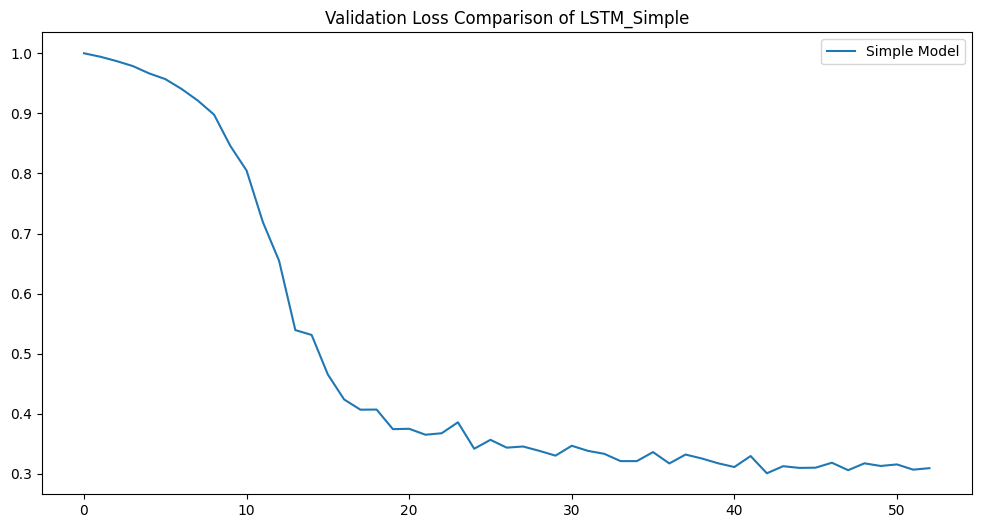

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(history_simple.history['val_loss'], label='Simple Model')
plt.legend()
plt.title('Validation Loss Comparison of LSTM_Simple')
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
y_pred_scaled = model_LSTM_simple.predict(X_test_scaled)
y_pred_scaled = scaler_y.inverse_transform(y_pred_scaled)
y_test = y_test.reshape(-1,1)
rmse_lstm_simple = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
mape_lstm_simple = mean_absolute_percentage_error(y_test, y_pred_scaled)
r2_lstm_simple = r2_score(y_test, y_pred_scaled)
print(f"R^2 is {r2_lstm_simple} \n RMSE is {rmse_lstm_simple} \n MAPE is {mape_lstm_simple}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
R^2 is 0.42539042234420776 
 RMSE is 6499.826459221816 
 MAPE is 0.05376782640814781


In [21]:
#Creating a new dataframe to compare the methods in the end.
result_data = {"Method":["LSTM - Simple"],
               "R^2":[r2_lstm_simple],
               "RMSE":[rmse_lstm_simple],
               "MAPE":[mape_lstm_simple]}
results_df = pd.DataFrame(data=result_data)
results_df

2025-03-21 12:36:08,490	INFO worker.py:1852 -- Started a local Ray instance.


,Method,R^2,RMSE,MAPE
0,LSTM - Simple,0.42539,6499.826459,0.053768


In [22]:
from tensorflow.keras.regularizers import l2
model_LSTM_normal = Sequential([
    LSTM(64,input_shape=(X_train_scaled.shape[1],1),kernel_regularizer=l2(0.001),return_sequences=False),
    Dropout(0.2),
    Dense(32,activation="relu",kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])

model_LSTM_normal.compile(optimizer="adam",loss="mae")

history_simple = model_LSTM_normal.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

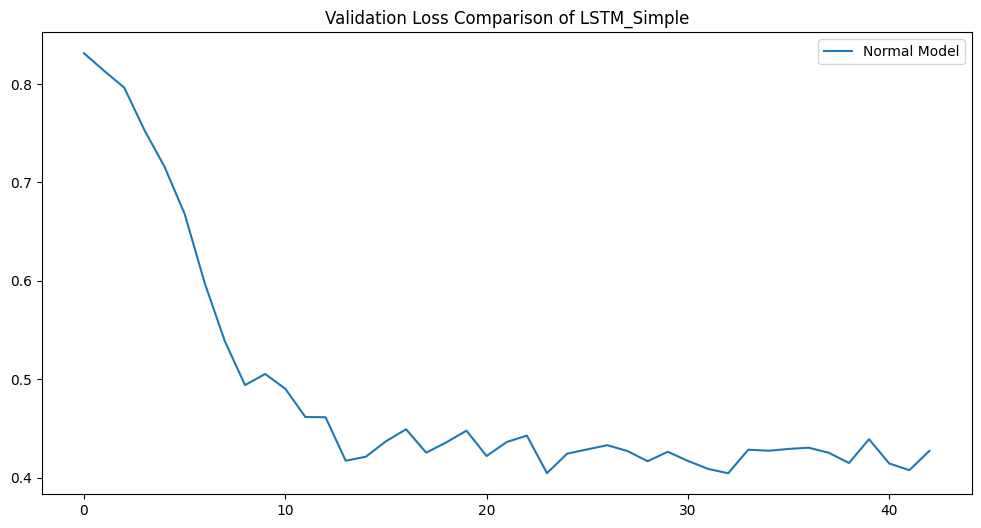

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(history_simple.history['val_loss'], label='Normal Model')
plt.legend()
plt.title('Validation Loss Comparison of LSTM_Simple')
plt.show()

In [28]:
y_pred_scaled = model_LSTM_normal.predict(X_test_scaled)
y_pred_scaled = scaler_y.inverse_transform(y_pred_scaled)
y_test = y_test.reshape(-1,1)
rmse_lstm_normal = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
mape_lstm_normal = mean_absolute_percentage_error(y_test, y_pred_scaled)
r2_lstm_normal = r2_score(y_test, y_pred_scaled)
print(f"R^2 is {r2_lstm_normal} \n RMSE is {rmse_lstm_normal} \n MAPE is {mape_lstm_normal}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
R^2 is 0.5529996156692505 
 RMSE is 5732.832982042997 
 MAPE is 0.0458378829061985


In [31]:
result_data = {"Method":["LSTM - Normal"],
               "R^2":[r2_lstm_normal],
               "RMSE":[rmse_lstm_normal],
               "MAPE":[mape_lstm_normal]}
results_df = pd.concat([results_df,pd.DataFrame(result_data)],ignore_index=True)
results_df

,Method,R^2,RMSE,MAPE
0,LSTM - Simple,0.42539,6499.826459,0.053768
1,LSTM - Normal,0.55300,5732.832982,0.045838


In [30]:
results_df.drop(index=1,inplace=True)

In [32]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional

In [33]:
model_LSTM_advanced = Sequential([
    Bidirectional(LSTM(128, return_sequences=True,
                       kernel_regularizer=l2(0.001),
                       recurrent_dropout=0.2),
                  input_shape=(X_train_scaled.shape[1],1)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=False,
                       kernel_regularizer=l2(0.001),
                       recurrent_dropout=0.2)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(1)
])

In [35]:
model_LSTM_advanced.compile(optimizer="adam",loss="mae")

history_simple = model_LSTM_advanced.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 251ms/step - loss: 0.5682 - val_loss: 0.6032
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - loss: 0.5436 - val_loss: 0.5963
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - loss: 0.5166 - val_loss: 0.5715
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - loss: 0.5174 - val_loss: 0.5275
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - loss: 0.5226 - val_loss: 0.5569
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step - loss: 0.4901 - val_loss: 0.5113
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - loss: 0.4858 - val_loss: 0.5118
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - loss: 0.5050 - val_loss: 0.5389
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - loss: 0.4584 - val_loss: 0.5182
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 216ms/step - loss: 0.4723 - val_loss: 0.5028
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 244ms/step - loss: 0.4523 - val_loss: 0.5152
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━

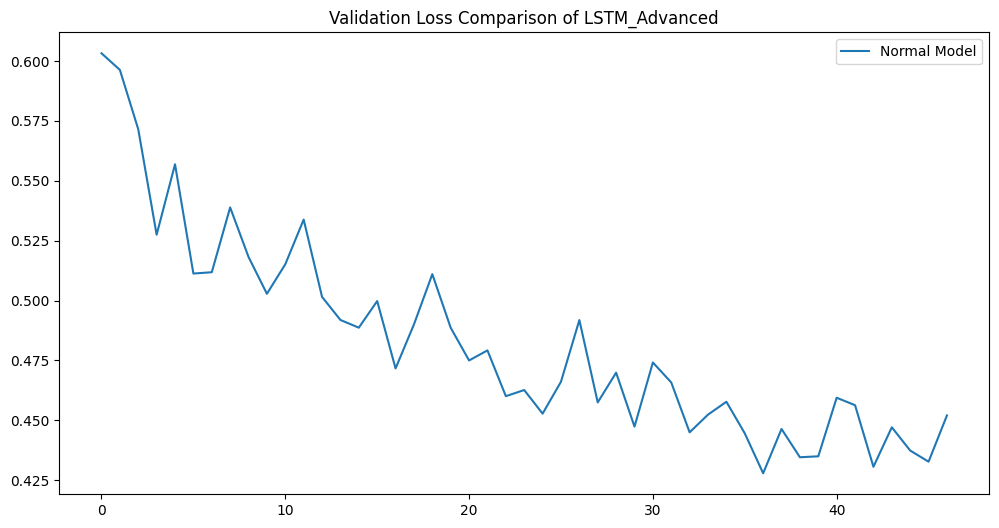

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(history_simple.history['val_loss'], label='Normal Model')
plt.legend()
plt.title('Validation Loss Comparison of LSTM_Advanced')
plt.show()

In [41]:
y_pred_scaled = model_LSTM_advanced.predict(X_test_scaled)
y_pred_scaled = scaler_y.inverse_transform(y_pred_scaled)
y_test = y_test.reshape(-1,1)
rmse_lstm_advanced = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
mape_lstm_advanced = mean_absolute_percentage_error(y_test, y_pred_scaled)
r2_lstm_advanced = r2_score(y_test, y_pred_scaled)
print(f"R^2 is {r2_lstm_advanced} \n RMSE is {rmse_lstm_advanced} \n MAPE is {mape_lstm_advanced}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
R^2 is 0.5770177841186523 
 RMSE is 5576.688264552718 
 MAPE is 0.0419011190533638


In [42]:
result_data = {"Method":["LSTM - Advance"],
               "R^2":[r2_lstm_advanced],
               "RMSE":[rmse_lstm_advanced],
               "MAPE":[mape_lstm_advanced]}
results_df = pd.concat([results_df,pd.DataFrame(result_data)],ignore_index=True)
results_df

,Method,R^2,RMSE,MAPE
0,LSTM - Simple,0.425390,6499.826459,0.053768
1,LSTM - Normal,0.553000,5732.832982,0.045838
2,LSTM - Advance,0.577018,5576.688265,0.041901


# RNN

In [43]:
from tensorflow.keras.layers import SimpleRNN

In [45]:
model_RNN_simple = Sequential([
    SimpleRNN(32, input_shape=(X_train_scaled.shape[1], 1), kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])
model_RNN_simple.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
history_rnn = model_RNN_simple.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 1.0354 - mae: 0.7071 - val_loss: 0.4678 - val_mae: 0.5391
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4917 - mae: 0.4447 - val_loss: 0.4096 - val_mae: 0.5120
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5906 - mae: 0.4427 - val_loss: 0.3515 - val_mae: 0.4629
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4645 - mae: 0.3916 - val_loss: 0.3367 - val_mae: 0.4536
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5817 - mae: 0.3915 - val_loss: 0.3125 - val_mae: 0.4324
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6161 - mae: 0.3941 - val_loss: 0.3391 - val_mae: 0.4548
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5312 - mae: 0.3921 - val_loss: 0.2989 - val_mae: 0.4204
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6102 - mae: 0.3971 - val_loss: 0.3253 - val_mae: 0.4465
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.59

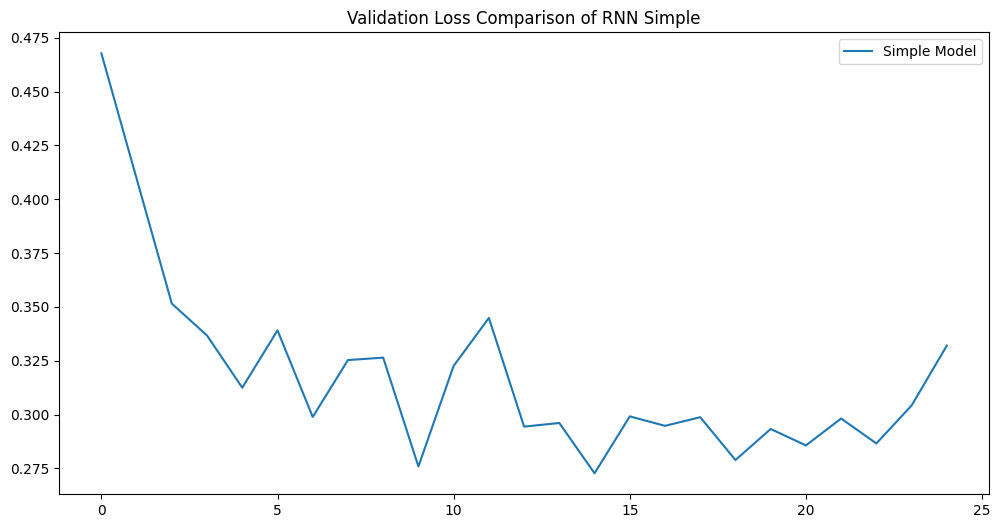

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(history_rnn.history['val_loss'], label='Simple Model')
plt.legend()
plt.title('Validation Loss Comparison of RNN Simple')
plt.show()

In [47]:
y_pred_scaled = model_RNN_simple.predict(X_test_scaled)
y_pred_scaled = scaler_y.inverse_transform(y_pred_scaled)
y_test = y_test.reshape(-1,1)
rmse_rnn_simple = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
mape_rnn_simple = mean_absolute_percentage_error(y_test, y_pred_scaled)
r2_rnn_simple = r2_score(y_test, y_pred_scaled)
print(f"R^2 is {r2_rnn_simple} \n RMSE is {rmse_rnn_simple} \n MAPE is {mape_rnn_simple}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
R^2 is 0.5731147527694702 
 RMSE is 5602.358431946317 
 MAPE is 0.04508863016963005


In [48]:
result_data = {"Method":["RNN - Simple"],
               "R^2":[r2_rnn_simple],
               "RMSE":[rmse_rnn_simple],
               "MAPE":[mape_rnn_simple]}
results_df = pd.concat([results_df,pd.DataFrame(result_data)],ignore_index=True)
results_df

,Method,R^2,RMSE,MAPE
0,LSTM - Simple,0.425390,6499.826459,0.053768
1,LSTM - Normal,0.553000,5732.832982,0.045838
2,LSTM - Advance,0.577018,5576.688265,0.041901
3,RNN - Simple,0.573115,5602.358432,0.045089


In [49]:
model_RNN_normal = Sequential([
    SimpleRNN(64, input_shape=(X_train_scaled.shape[1], 1), kernel_regularizer=l2(0.001), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])

model_RNN_normal.compile(optimizer="adam", loss="mae")

history_rnn = model_RNN_normal.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

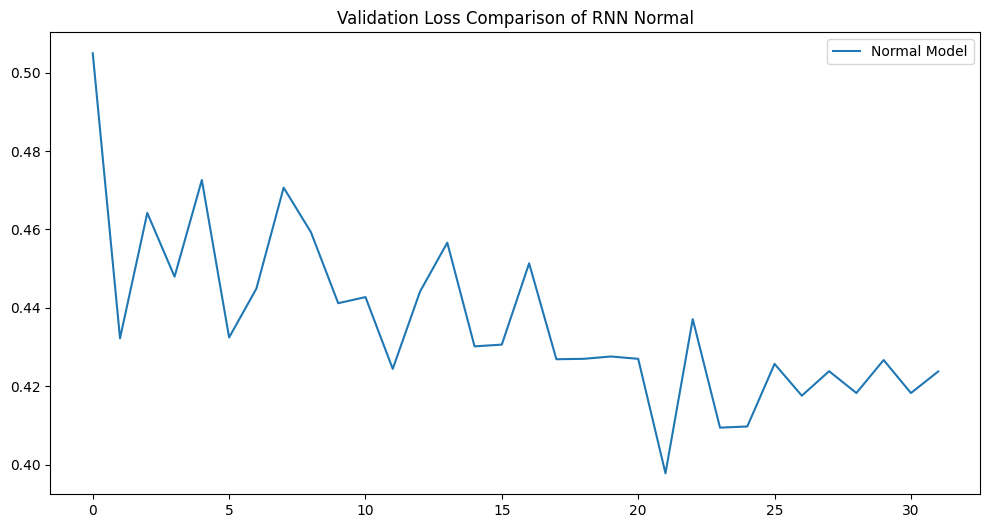

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(history_rnn.history['val_loss'], label='Normal Model')
plt.legend()
plt.title('Validation Loss Comparison of RNN Normal')
plt.show()

In [52]:
y_pred_scaled = model_RNN_normal.predict(X_test_scaled)
y_pred_scaled = scaler_y.inverse_transform(y_pred_scaled)
y_test = y_test.reshape(-1,1)
rmse_rnn_normal = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
mape_rnn_normal = mean_absolute_percentage_error(y_test, y_pred_scaled)
r2_rnn_normal = r2_score(y_test, y_pred_scaled)
print(f"R^2 is {r2_rnn_normal} \n RMSE is {rmse_rnn_normal} \n MAPE is {mape_rnn_normal}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
R^2 is 0.5750077962875366 
 RMSE is 5589.922718607118 
 MAPE is 0.04425815865397453


In [55]:
result_data = {"Method":["RNN - Normal"],
               "R^2":[r2_rnn_normal],
               "RMSE":[rmse_rnn_normal],
               "MAPE":[mape_rnn_normal]}
results_df = pd.concat([results_df,pd.DataFrame(result_data)],ignore_index=True)
results_df

,Method,R^2,RMSE,MAPE
0,LSTM - Simple,0.425390,6499.826459,0.053768
1,LSTM - Normal,0.553000,5732.832982,0.045838
2,LSTM - Advance,0.577018,5576.688265,0.041901
3,RNN - Simple,0.573115,5602.358432,0.045089
4,RNN - Normal,0.575008,5589.922719,0.044258
5,RNN - Normal,0.575008,5589.922719,0.044258
6,RNN - Normal,0.575008,5589.922719,0.044258
